<a href="https://colab.research.google.com/github/taishi-i/nagisa_bert/blob/develop/notebooks/text_classification-amazon_reviews_ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers による文書分類モデルの作成 🤗

このノートブックでは、amazon_reviews データセットを利用して、日本語のアマゾンレビューのタイトルからレビュースコアを予測するモデルを作成します。

データセットのダウンロードなどは必要なく、Colab 上で全ての処理を実行することができます。

BERTモデルの選択から、Hugging Face にモデルファイルをアップロードする方法まで、一連の方法を説明します。

## ライブラリのインストール

In [ ]:
!pip install datasets
!pip install nagisa_bert # taishi-i/nagisa_bert
!pip install fugashi
!pip install ipadic # cl-tohoku/bert-base-japanese-whole-word-masking
!pip install unidic-lite # cl-tohoku/bert-base-japanese-v2

## ライブラリのインポート

In [ ]:
import torch

from datasets import load_dataset

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from nagisa_bert import NagisaBertTokenizer
from transformers import BertJapaneseTokenizer

from transformers import Trainer
from transformers import TrainingArguments

from transformers import AutoModelForSequenceClassification

## 利用する言語モデル（BERTモデルの種類）の指定

In [ ]:
model_name = "taishi-i/nagisa_bert"
# model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
# model_name = "cl-tohoku/bert-base-japanese-v2"

if model_name == "taishi-i/nagisa_bert":
    tokenizer = NagisaBertTokenizer.from_pretrained(model_name)
else:
     tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)   

## amazon_reviews_multi データのダウンロード

In [ ]:
X_type = "review_title"
# X_type = "review_body"

Y_type = "stars"
# Y_type = "product_category"

amazon_reviews_ja = load_dataset("amazon_reviews_multi", "ja")
label2id = {label:i for i, label in enumerate(list(set(amazon_reviews_ja["train"][Y_type])))}
id2label = {id:label for label, id in label2id.items()}

## データセットの変換

tokenize() 関数により、テキストデータのid化、ラベルのid化を行います。

In [ ]:
def tokenize(batch):
    tokenized_batch = tokenizer(batch[X_type], padding=True, truncation=True)
    tokenized_batch["label"] = [label2id[label] for label in batch[Y_type]]
    return tokenized_batch

In [ ]:
amazon_reviews_ja_encoded = amazon_reviews_ja.map(
    tokenize, batched=True, batch_size=None
)

## 文書分類モデルの指定

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(set(amazon_reviews_ja_encoded["train"]["label"]))
model = (AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels).to(device))

## 学習の設定

学習用パラメータは、ほぼデフォルトに設定しています。

ここでは、学習時間の短縮のために num_train_epochs=1 に、記憶領域の節約のために save_total_limit=1 とデフォルト値より変更しています。。

[TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) を参考に、パラメータを変更してください。

In [ ]:
output_dir = f"{model_name}-text-classification"

training_args = TrainingArguments(
    output_dir=model_name,
    save_total_limit=1,
    num_train_epochs=1,
    report_to=None
)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics, 
    train_dataset=amazon_reviews_ja_encoded["train"], 
    eval_dataset=amazon_reviews_ja_encoded["validation"], 
    tokenizer=tokenizer
)

## 学習の実行

In [ ]:
trainer.train()

## モデルの評価

In [ ]:
preds_output = trainer.predict(amazon_reviews_ja_encoded["test"])
preds_output.metrics

## モデルの保存

In [ ]:
trainer.model.config.label2id = label2id
trainer.model.config.id2label = id2label

In [ ]:
save_model_file = f"amazon_reviews_ja_{X_type}_{Y_type}"
trainer.save_model(save_model_file)

## Hugging Face へのモデルのアップロード

trainer.save_model(save_model_file) により保存されたファイルを Hugging Face の Files から手動でアップロードすることもできます。

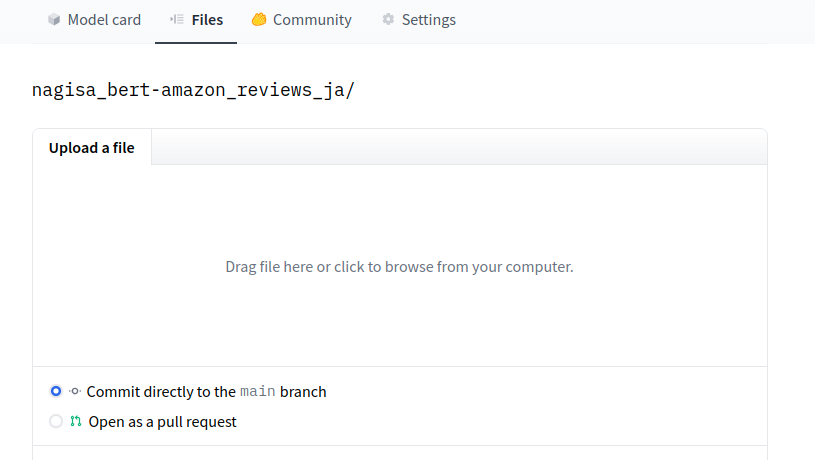

保存されたファイルを全てアップロードすると、Hugging Face よりモデルを呼び出すことができます。

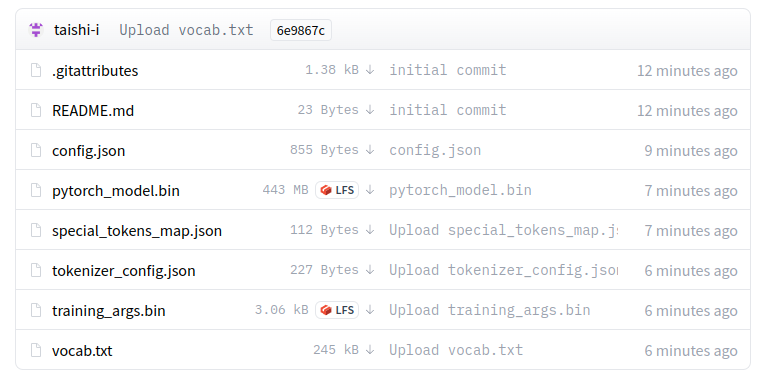

## Pipeline によるモデルの推論結果の確認

Hugging Face にアップロードしたモデルを利用する場合は、**model=save_model_file のファイル名**を変更してください。

「また欲しい商品です！」を入力とすると、'label': 5 のスコアが最も高い結果を得ることができます。

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model=save_model_file, tokenizer=tokenizer)
text = "また欲しい商品です！"
preds = classifier(text, return_all_scores=True)
print(preds)

## 結果

各モデルのテストデータに対する評価結果です。

In [ ]:
# taishi-i/nagisa_bert
{'test_loss': 1.1617640256881714,
 'test_accuracy': 0.4832,
 'test_f1': 0.47682799677040655,
 'test_runtime': 8.368,
 'test_samples_per_second': 597.514,
 'test_steps_per_second': 74.689}

# cl-tohoku/bert-base-japanese-whole-word-masking
{'test_loss': 1.154637098312378,
 'test_accuracy': 0.48,
 'test_f1': 0.47371245634641235,
 'test_runtime': 9.3141,
 'test_samples_per_second': 536.822,
 'test_steps_per_second': 67.103}

# cl-tohoku/bert-base-japanese-v2
{'test_loss': 1.1508225202560425,
 'test_accuracy': 0.4892,
 'test_f1': 0.4791654107638944,
 'test_runtime': 8.7809,
 'test_samples_per_second': 569.42,
 'test_steps_per_second': 71.177}